# ...in Python

# SEC EDGAR API in Python

by Michael T. Moen

**SEC EDGAR API documentation**: [https://www.sec.gov/os/accessing-edgar-data](https://www.sec.gov/os/accessing-edgar-data)

**SEC Website Policies**: [https://www.sec.gov/privacy#security](https://www.sec.gov/privacy#security)

**List of all CIKs**: [https://www.sec.gov/Archives/edgar/cik-lookup-data.txt](https://www.sec.gov/Archives/edgar/cik-lookup-data.txt)

**_NOTE:_** Sending more than 10 requests per second will place a temporary ban on your IP.

These recipe examples were tested in September 2023.

### User Agent Information

The SEC EDGAR API requires you to provide your name and email when sending requests. Simply edit the 'myinfo' dictionary with your personal info.

In [37]:
myinfo = {"User-agent": "FirstName LastName, email"}

Alternatively, you can save the above data in a separate python file and import it:

In [38]:
from agent_info import myinfo

### SEC EDGAR Data Installation

In addition to the publicly available API, SEC EDGAR data can also be access via a bulk data download, which is compiled nightly. This approach is advantageous when working with large datasets, since it does not require making many individual API calls. However, it requires about 15 GB of storage to install and is more difficult to keep up to date.

To access this data, download the companyfacts.zip file under the 'Bulk data' heading at the bottom of [this page](https://www.sec.gov/edgar/sec-api-documentation).

## 1. Obtaining Marketing Expenses for Amazon

First, we have to import a few libraries:

In [39]:
# The following libraries are used in this guide
import requests                     # manages API requests
from pprint import pprint           # creates more readable outputs
import matplotlib.pyplot as plt     # creates visualization of data
from math import log10              # used to perform the log operation
import csv                          # used for writing to a .csv file

To access the data from an individual company, we must first obtain its Central Index Key (CIK) value. These values can be obtained by searching for a company [here](https://www.sec.gov/edgar/search/#). Alternatively, you can find a list of all companies and their CIK value [here](https://www.sec.gov/Archives/edgar/cik-lookup-data.txt).

For this section of the guide, we'll use Amazon (AMZN) as an example, which has a CIK of 0001018724.

With this CIK, we can now build a URL for the /companyfacts/ endpoint:

In [40]:
cik = '0001018724'
url = f'https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json'

data_retrieved = requests.get(url, headers=myinfo).json()

Now, we can look at all of the data included in that API request:

In [41]:
# output too large to display, uncomment the following line to view
# data_retrieved

We can also access individual pieces of information with our retrieved data:

**_NOTE:_** It may be useful to open the [url](https://data.sec.gov/api/xbrl/companyfacts/CIK0001018724.json) we created in Firefox, which has a built in JSON viewer that other browsers lack.

In [42]:
company_name = data_retrieved['entityName']
company_name

'AMAZON.COM, INC.'

For an example, let's look at the yearly marketing expenses of Amazon, which is defined as "Expenditures for planning and executing the conception, pricing, promotion, and distribution of ideas, goods, and services. Costs of public relations and corporate promotions are typically considered to be marketing costs."

In [43]:
# this navigates the JSON data structure to get us to the marketing expenses data
marketing_expenses = data_retrieved['facts']['us-gaap']['MarketingExpense']['units']['USD']

total_marketing_expenses = 0    # sum of marketing expenses in period
yearly_marketing_expenses = []  # list of tuples with (year, value) pairings

# iterate through list of marketing expense data in filings
for expense in marketing_expenses:
    
    # checks if the filing period in the entry is a filing year,
    # so that we don't double-count by also adding data from quarterly filings
    if expense['fp'] == 'FY':
        
        # checks if the filing year is already in yearly_marketing_expenses, so as to not duplicate the data
        if not any(expense['start'][:4] in i for i in yearly_marketing_expenses):
            
            total_marketing_expenses += expense['val']
            yearly_marketing_expenses.append((expense['start'][:4], expense['val']))
        
# display results
for expense in yearly_marketing_expenses:
    print(f'{expense[0]}: ${expense[1]}')
print(f'Total marketing expense of {company_name} from {yearly_marketing_expenses[0][0]} to {yearly_marketing_expenses[-1][0]} is ${total_marketing_expenses}')

2007: $344000000
2008: $482000000
2009: $680000000
2010: $1029000000
2011: $1630000000
2012: $2408000000
2013: $3133000000
2014: $4332000000
2015: $5254000000
2016: $7233000000
2017: $10069000000
2018: $13814000000
2019: $18878000000
2020: $22008000000
2021: $32551000000
2022: $42238000000
Total marketing expense of AMAZON.COM, INC. from 2007 to 2022 is $166083000000


The following code block scales the data so that the y-axis of our graph contains smaller numbers that can be more easily understood, rather than large values in the billions.

In [25]:
# breaks up the list of tuples forming 'yearly_expenses' into two separate lists
years, expenses = zip(*yearly_marketing_expenses)

# create scale for bar graph
min = sorted(list(expenses), key=float)[0]
exponent = len(str(int(min)))

# changes the data to fit the scale
expenses = [x/(10**exponent) for x in expenses]

Finally, we can plot the data:

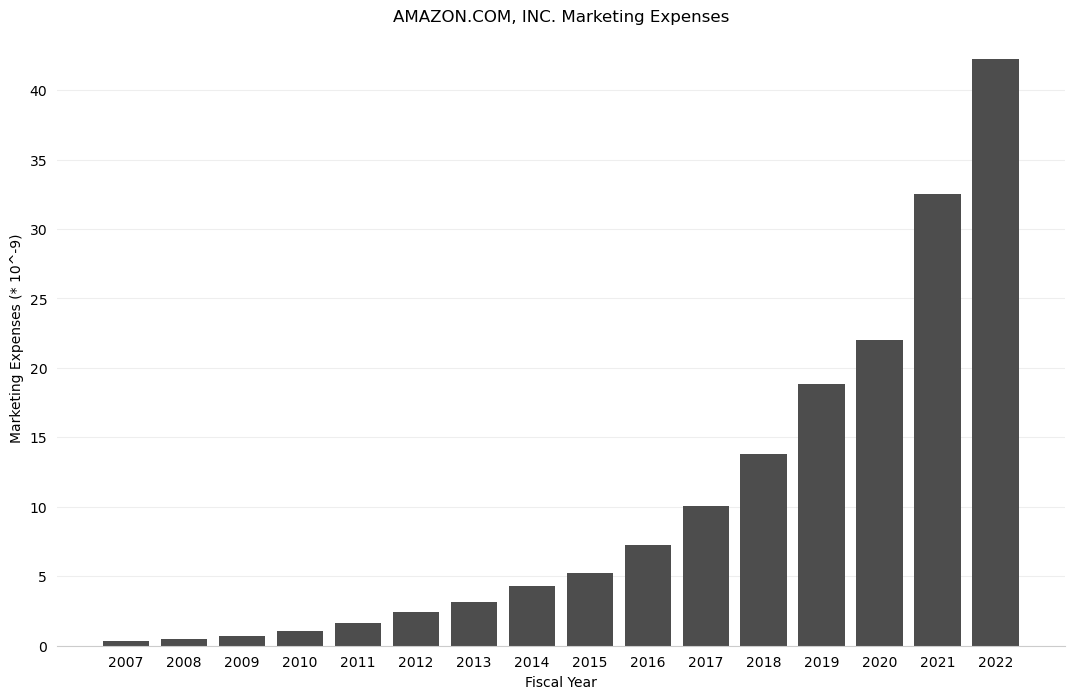

In [26]:
# create graphing window with size 13x8
fig, ax = plt.subplots(figsize=(13,8))

# format the bar graph
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#CCCCCC')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# plot the graph and add titles
plt.bar(years, expenses, color='#4d4d4d')
plt.title(company_name + " Marketing Expenses")
plt.xlabel("Fiscal Year")
plt.ylabel(f"Marketing Expenses (* 10^-{exponent})")

# this saves the graph as a .png image; comment the line out if you do not wish for this
plt.savefig(f'{company_name} marketing expenses.png')

# this shows the graph in the Jupyter Notebook
plt.show()

Note that the scaling of the data allowed us to present the data in terms of billions of dollars.

## 2. Number of Shares Outstanding for Tesla

For another use case, let's look at the number of shares outstanding for Tesla, which the SEC defines as "Number of shares of common stock outstanding. Common stock represent the ownership interest in a corporation."

In [27]:
# cik value for Tesla
cik = '0001318605'
url = f'https://data.sec.gov/api/xbrl/companyfacts/CIK{cik}.json'

data_retrieved = requests.get(url, headers=myinfo).json()

company_name = data_retrieved['entityName']

We can find this data using a similar process as we used in part 1:

In [28]:
# this navigates the JSON data structure to get us to the total sharess data
shares_outstanding = data_retrieved['facts']['us-gaap']['CommonStockSharesOutstanding']['units']['shares']

yearly_shares = []      # list of tuples with (year, value) pairings

# iterate through list of marketing expense data in filings
for entry in shares_outstanding:
    
    # checks if the filing period in the entry is a filing year,
    # so that we don't double-count by adding data from quarterly filings
    if entry['fp'] == 'FY':
        
        # checks if the filing year is already in yearly_shares, so as to not duplicate the data
        if not any(entry['fy'] in i for i in yearly_shares):
            
            yearly_shares.append((entry['fy'], entry['val']))

# display results
yearly_shares

[(2011, 94908370),
 (2012, 104530305),
 (2013, 114214274),
 (2014, 123090990),
 (2015, 125688000),
 (2016, 131425000),
 (2017, 161561000),
 (2018, 168797000),
 (2019, 173000000),
 (2020, 905000000),
 (2021, 960000000),
 (2022, 3100000000)]

## 3. Comparing Total Assets of All Filing Companies

The SEC EDGAR API also has an endpoint called /frames/ that returns the data from all companies for a given category and filing period. In this example, we'll look at the total assets of all companies reported for Q1 2023.

In [29]:
# categories can be found in the JSON data obtained from the /companyfacts/ endpoint
# note that you also must include the units name for some categories (in this case, USD)
category = 'Assets/USD'
year = '2023'
quarter = '1'
url = f'https://data.sec.gov/api/xbrl/frames/us-gaap/{category}/CY{year}Q{quarter}I.json'

data_retrieved = requests.get(url, headers=myinfo).json()

# display number of results
len(data_retrieved['data'])

6183

Now, let's retrieve the company names and asset values of all of the companies. Below, we store this data as a list of tuples in the total_assets list and sort it:

In [30]:
# use list comprehension to build list of tuples with (companyName, value) pairings
total_assets = [(entry['entityName'], int(entry['val'])) for entry in data_retrieved['data']]

# sort list of tuples by value of second part of tuple, and reverse to put highest values on top
total_assets = sorted(total_assets, key = lambda x: x[1])
total_assets.reverse()

# display top 20 results
total_assets[:20]

[('FEDERAL NATIONAL MORTGAGE ASSOCIATION FANNIE MAE', 4317460000000),
 ('JPMorgan Chase & Co', 3744305000000),
 ('Federal Home Loan Mortgage Corporation', 3224980000000),
 ('Bank of America Corporation', 3194657000000),
 ('Citigroup\xa0Inc', 2455113000000),
 ('WELLS FARGO & COMPANY/MN', 1886400000000),
 ('The Goldman Sachs Group, Inc.', 1538349000000),
 ('MORGAN STANLEY', 1199904000000),
 ('BERKSHIRE HATHAWAY INC', 997072000000),
 ('Prudential Financial, Inc.', 709269000000),
 ('US BANCORP \\DE\\', 682377000000),
 ('MetLife, Inc.', 674266000000),
 ('TRUIST FINANCIAL CORPORATION', 574354000000),
 ('PNC Financial Services Group, Inc.', 561777000000),
 ('American International Group, Inc.', 536627000000),
 ('SCHWAB CHARLES CORP', 535552000000),
 ('CAPITAL\xa0ONE\xa0FINANCIAL\xa0CORP', 471660000000),
 ('AMAZON.COM, INC.', 464378000000),
 ('THE BANK OF NEW YORK MELLON CORPORATION', 425112000000),
 ('AT&T INC.', 400873000000)]

We can export the full dataset to a comma separated values (.csv) file. This will allow us to view an manipulate the data in a program such as Microsoft Excel.

In [31]:
with open(f'companies_by_total_assets_q{quarter}_{year}.csv', 'w', newline='') as f:
    csv_out = csv.writer(f)
    csv_out.writerows(total_assets)

### Graphing the Total Assets of All Companies

Since the total assets of all companies is a dataset that ranges from values as low as zero to those as large as 4.3 trillion, these values must be graphed logarithmically. Below, we take the log<sub>10</sub> of each of the total asset values so that we can group the total assets in groups of ones (10<sup>0</sup>), tens (10<sup>1</sup>), hundreds (10<sup>2</sup>), thousands (10<sup>3</sup>), and so on. Then, we'll use matplotlib to graph these values with a histogram.

**_Note:_** Since 0 is outside the domain of the log function, it must be handled separately in order to avoid throwing an error. In this case, we group these values into the ones (10<sup>0</sup>) group, although this is not actually true.

In [32]:
weighted_vals = []  # list of log10(total_assets) for each company

for company in total_assets:
    if company[1] == 0:
        weighted_vals.append(0)
    else:
        weighted_vals.append(log10(company[1]))

n_bins = int(max(weighted_vals))+1  # number of bins to put data into for the histogram
bins = range(n_bins+1)              # bin titles

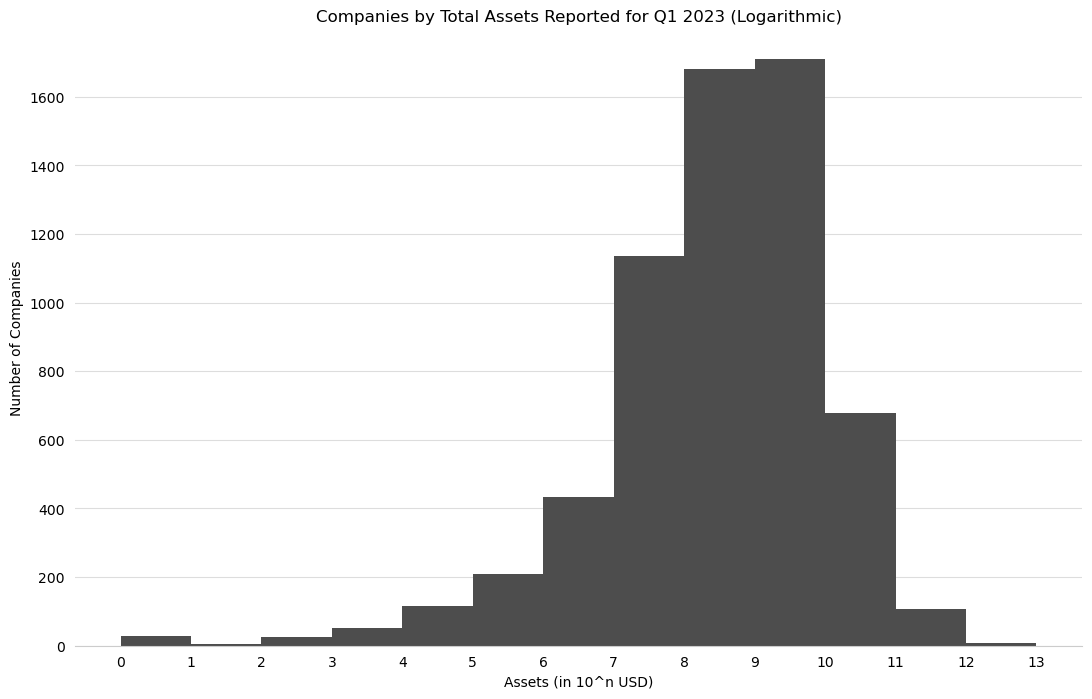

In [33]:
# create graphing window with size 13x8
fig, ax = plt.subplots(figsize=(13,8))

# format the bar graph
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#CCCCCC')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#DDDDDD')
ax.xaxis.grid(False)
ax.set_xticks(bins)

# plot the graph and add titles
plt.hist(weighted_vals, color='#4d4d4d', bins=bins)
plt.title(f"Companies by Total Assets Reported for Q{quarter} {year} (Logarithmic)")
plt.xlabel("Assets (in 10^n USD)")
plt.ylabel(f"Number of Companies")

# this saves the graph as a .png image; comment the line out if you do not wish for this
plt.savefig(f'companies_by_total_assets_q{quarter}_{year}.png')

# this shows the graph in the Jupyter Notebook
plt.show()

Note that for the above data, the 0-1 bucket indicates that a company reported between 0 and 9 USD in assets, while the 12-13 bucket indicates that a company reported between 10<sup>12</sup> and 10<sup>13</sup> (or one trillion and ten trillion) USD in assets.

## 4. Finding the Top 500 Companies by Revenue

The Fortune 500 is a ranking of the top 500 companies by revenue, according to the data filed in their 10-K or a comparable form. In this example, we'll look at only the revenues reported in the 10-K forms to construct a similar ranking of U.S. companies by revenue.

In [34]:
category = 'Revenues/USD'
year = '2022'
url = f'https://data.sec.gov/api/xbrl/frames/us-gaap/{category}/CY{year}.json'

data_retrieved = requests.get(url, headers=myinfo).json()

# display number of results
len(data_retrieved['data'])

2405

Now, we can sort this data by value and keep the top 500 results:

In [35]:
# list of tuples with ('company name', revenue) pairings assembled using list comprehension
total_revenues = [(entry['entityName'], entry['val']) for entry in data_retrieved['data']]

# sort total_revenues by revenues, reverse to put the greatest values on top, and keep top 500 results
total_revenues = sorted(total_revenues, key = lambda x: x[1])
total_revenues.reverse()
total_revenues = total_revenues[:500]

# display top 10 results
total_revenues[:10]

[('WALMART INC.', 611289000000),
 ('Exxon Mobil Corporation', 413680000000),
 ('UnitedHealth Group Incorporated', 324162000000),
 ('CVS HEALTH CORP', 322467000000),
 ('BERKSHIRE HATHAWAY INC', 302089000000),
 ('Chevron Corp', 246252000000),
 ('AMERISOURCEBERGEN CORP', 238587006000),
 ('COSTCO WHOLESALE CORP /NEW', 226954000000),
 ('Cardinal Health, Inc.', 181364000000),
 ('The Cigna Group', 180516000000)]

Finally, we can export this data as a .csv file:

In [36]:
with open(f'top_500_companies_by_revenue_fy{year}.csv', 'w', newline='') as f:
    csv_out = csv.writer(f)
    csv_out.writerows(total_revenues)